In [ ]:
# !pip install tensorflow==1.15

In [1]:
from tensorflow import keras 

In [2]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd

# from keras.models import Sequential
# from keras.layers import Dense, LSTM, Embedding, RepeatVector
# from keras.preprocessing.text import Tokenizer
# from keras.callbacks import ModelCheckpoint
# from keras.preprocessing.sequence import pad_sequences
# from keras.models import load_model
# from keras import optimizers

from tensorflow import keras as k 

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [4]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [5]:
# split a text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [ ]:
%%bash
wget 'http://www.manythings.org/anki/deu-eng.zip'

In [12]:
%%bash 
unzip /content/deu-eng.zip

Archive:  /content/deu-eng.zip
  inflating: deu.txt                 
  inflating: _about.txt              


In [13]:
# Dataset D:\01-Works\00-Doc-to-Sync\0-Download\deu-eng
# http://www.manythings.org/anki/
file = r'D:\01-Works\00-Doc-to-Sync\0-Download\deu-eng\deu.txt'	  
file = r'/content/deu.txt'
data = read_text(file)
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [14]:
deu_eng = deu_eng[:50000,:]
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Tom is still sitting.', 'Tom sitzt noch.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2273521 (CK) & #10190706 (wolfgangth)'],
       ['Tom is still smoking.', 'Tom raucht immer noch.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2646953 (CK) & #8072723 (Luiaard)'],
       ['Tom is still talking.', 'Tom spricht noch.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2646952 (CK) & #10150806 (wolfgangth)']],
      dtype='<U537')

# (a) Text Cleaning

In [15]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]


In [16]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

# (b) Text to Sequence Conversion

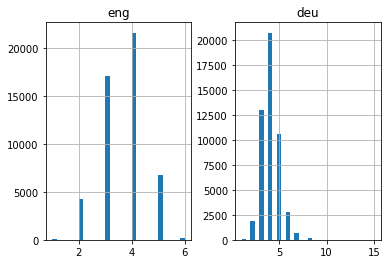

In [17]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [18]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = k.preprocessing.text.Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [19]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

In [20]:
eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6123


In [21]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

In [22]:
deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10081


In [23]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = k.preprocessing.sequence.pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [24]:
# Model Building 
from sklearn.model_selection import train_test_split

In [25]:
# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [26]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [27]:
# build NMT model - Neural Machine Translation
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = k.Sequential()
      model.add(k.layers.Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(k.layers.LSTM(units))
      model.add(k.layers.RepeatVector(out_timesteps))
      model.add(k.layers.LSTM(units, return_sequences=True))
      model.add(k.layers.Dense(out_vocab, activation='softmax'))
      return model
	  

In [28]:
 # model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)


In [29]:
rms = k.optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [30]:
filename = 'model.h1.24_jan_19'
checkpoint = k.callbacks.ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 3.3292
Epoch 1: val_loss improved from inf to 2.79435, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 291s 5s/step - loss: 3.3292 - val_loss: 2.7943
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 2.6953
Epoch 2: val_loss improved from 2.79435 to 2.66271, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 284s 5s/step - loss: 2.6953 - val_loss: 2.6627
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 2.5312
Epoch 3: val_loss improved from 2.66271 to 2.49506, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 286s 5s/step - loss: 2.5312 - val_loss: 2.4951
Epoch 4/30
63/63 [==============================] - ETA: 0s - loss: 2.3564
Epoch 4: val_loss improved from 2.49506 to 2.36856, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 280s 4s/step - loss: 2.3564 - val_loss: 2.3686
Epoch 5/30
63/63 [==============================] - ETA: 0s - loss: 2.2175
Epoch 5: val_loss improved from 2.36856 to 2.25152, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 280s 4s/step - loss: 2.2175 - val_loss: 2.2515
Epoch 6/30
63/63 [==============================] - ETA: 0s - loss: 2.0798
Epoch 6: val_loss improved from 2.25152 to 2.13709, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 279s 4s/step - loss: 2.0798 - val_loss: 2.1371
Epoch 7/30
63/63 [==============================] - ETA: 0s - loss: 1.9468
Epoch 7: val_loss improved from 2.13709 to 2.02756, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 280s 4s/step - loss: 1.9468 - val_loss: 2.0276
Epoch 8/30
63/63 [==============================] - ETA: 0s - loss: 1.8209
Epoch 8: val_loss improved from 2.02756 to 1.97384, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 282s 4s/step - loss: 1.8209 - val_loss: 1.9738
Epoch 9/30
63/63 [==============================] - ETA: 0s - loss: 1.7084
Epoch 9: val_loss improved from 1.97384 to 1.87250, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 281s 4s/step - loss: 1.7084 - val_loss: 1.8725
Epoch 10/30
63/63 [==============================] - ETA: 0s - loss: 1.6044
Epoch 10: val_loss improved from 1.87250 to 1.80423, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 287s 5s/step - loss: 1.6044 - val_loss: 1.8042
Epoch 11/30
63/63 [==============================] - ETA: 0s - loss: 1.5048
Epoch 11: val_loss improved from 1.80423 to 1.75526, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 284s 5s/step - loss: 1.5048 - val_loss: 1.7553
Epoch 12/30
63/63 [==============================] - ETA: 0s - loss: 1.4118
Epoch 12: val_loss improved from 1.75526 to 1.66954, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 284s 5s/step - loss: 1.4118 - val_loss: 1.6695
Epoch 13/30
63/63 [==============================] - ETA: 0s - loss: 1.3264
Epoch 13: val_loss improved from 1.66954 to 1.62127, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 280s 4s/step - loss: 1.3264 - val_loss: 1.6213
Epoch 14/30
63/63 [==============================] - ETA: 0s - loss: 1.2406
Epoch 14: val_loss improved from 1.62127 to 1.57201, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 276s 4s/step - loss: 1.2406 - val_loss: 1.5720
Epoch 15/30
63/63 [==============================] - ETA: 0s - loss: 1.1626
Epoch 15: val_loss improved from 1.57201 to 1.52173, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 278s 4s/step - loss: 1.1626 - val_loss: 1.5217
Epoch 16/30
63/63 [==============================] - ETA: 0s - loss: 1.0859
Epoch 16: val_loss did not improve from 1.52173
63/63 [==============================] - 263s 4s/step - loss: 1.0859 - val_loss: 1.5262
Epoch 17/30
63/63 [==============================] - ETA: 0s - loss: 1.0130
Epoch 17: val_loss improved from 1.52173 to 1.44846, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 282s 4s/step - loss: 1.0130 - val_loss: 1.4485
Epoch 18/30
63/63 [==============================] - ETA: 0s - loss: 0.9454
Epoch 18: val_loss improved from 1.44846 to 1.41674, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 281s 4s/step - loss: 0.9454 - val_loss: 1.4167
Epoch 19/30
63/63 [==============================] - ETA: 0s - loss: 0.8772
Epoch 19: val_loss improved from 1.41674 to 1.38899, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 279s 4s/step - loss: 0.8772 - val_loss: 1.3890
Epoch 20/30
63/63 [==============================] - ETA: 0s - loss: 0.8140
Epoch 20: val_loss improved from 1.38899 to 1.38137, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 279s 4s/step - loss: 0.8140 - val_loss: 1.3814
Epoch 21/30
63/63 [==============================] - ETA: 0s - loss: 0.7541
Epoch 21: val_loss improved from 1.38137 to 1.35147, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 279s 4s/step - loss: 0.7541 - val_loss: 1.3515
Epoch 22/30
63/63 [==============================] - ETA: 0s - loss: 0.6984
Epoch 22: val_loss improved from 1.35147 to 1.31940, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 278s 4s/step - loss: 0.6984 - val_loss: 1.3194
Epoch 23/30
63/63 [==============================] - ETA: 0s - loss: 0.6455
Epoch 23: val_loss improved from 1.31940 to 1.30844, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 280s 4s/step - loss: 0.6455 - val_loss: 1.3084
Epoch 24/30
63/63 [==============================] - ETA: 0s - loss: 0.5965
Epoch 24: val_loss improved from 1.30844 to 1.29202, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 281s 4s/step - loss: 0.5965 - val_loss: 1.2920
Epoch 25/30
63/63 [==============================] - ETA: 0s - loss: 0.5491
Epoch 25: val_loss improved from 1.29202 to 1.27371, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 279s 4s/step - loss: 0.5491 - val_loss: 1.2737
Epoch 26/30
63/63 [==============================] - ETA: 0s - loss: 0.5042
Epoch 26: val_loss improved from 1.27371 to 1.25438, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 282s 4s/step - loss: 0.5042 - val_loss: 1.2544
Epoch 27/30
63/63 [==============================] - ETA: 0s - loss: 0.4646
Epoch 27: val_loss improved from 1.25438 to 1.24558, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 282s 4s/step - loss: 0.4646 - val_loss: 1.2456
Epoch 28/30
63/63 [==============================] - ETA: 0s - loss: 0.4257
Epoch 28: val_loss improved from 1.24558 to 1.24449, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 279s 4s/step - loss: 0.4257 - val_loss: 1.2445
Epoch 29/30
63/63 [==============================] - ETA: 0s - loss: 0.3909
Epoch 29: val_loss improved from 1.24449 to 1.23730, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 283s 5s/step - loss: 0.3909 - val_loss: 1.2373
Epoch 30/30
63/63 [==============================] - ETA: 0s - loss: 0.3563
Epoch 30: val_loss did not improve from 1.23730
63/63 [==============================] - 265s 4s/step - loss: 0.3563 - val_loss: 1.2378


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [ ]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [ ]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [ ]:

	  
	  
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))
	   

pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})


# print 15 rows randomly
pred_df.sample(15)




